In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)
from sklearn.preprocessing import RobustScaler, StandardScaler

In [37]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [38]:
print(type(df["age"]))
print(df.shape)

<class 'pandas.core.series.Series'>
(299, 13)


In [39]:
columns = df.columns.tolist()

In [40]:
test = df["DEATH_EVENT"]
train = df.drop(["DEATH_EVENT"], axis=1)

In [41]:
print(type(df["sex"].unique()))
print(df["sex"].unique())
print(len(df["sex"].unique()) == 2)


<class 'numpy.ndarray'>
[1 0]
True


In [42]:
#数値変数はヒストグラムとボックスプロット
#カテゴリ変数にはカウントプロットを描写する関数を設定
def graph_insight(data, column):
    if len(data[column].unique()) == 2:
        plt.figure(figsize=(5, 3))
        sns.countplot(data=data, x=column)
    else:
        fig, axes = plt.subplots(1, 2, tight_layout=True)
        plt.figure(figsize=(10, 5))
        
        sns.histplot(data=data, x=column, kde=True, ax=axes[0])
        axes[0].set_title(column)
        sns.boxplot(data=data, x=column, ax=axes[1])
        axes[1].set_title(column)

In [43]:
columns = df.columns.tolist()

In [44]:
from sklearn.preprocessing import StandardScaler, RobustScaler

stdscaler = StandardScaler()
rbscaler = RobustScaler()

In [45]:
#外れ値を外し、標準化を行う
def scaler(column):
    if len(df[column].unique()) != 2:
        data = stdscaler.fit_transform(df[column].values.reshape(-1,1))
        data = rbscaler.fit_transform(data.reshape(-1,1)).flatten()
        return data

In [46]:
columns_cate = [x for x in columns if len(df[x].unique()) == 2]
columns_num = [x for x in columns if len(df[x].unique()) != 2]

func_scaled = map(lambda x: "scaled_"+x, columns_num)
new_columns_num = list(func_scaled)

In [47]:
print(new_columns_num)
dropped_df = df.drop([x for x in columns_num], axis=1)

['scaled_age', 'scaled_creatinine_phosphokinase', 'scaled_ejection_fraction', 'scaled_platelets', 'scaled_serum_creatinine', 'scaled_serum_sodium', 'scaled_time']


In [48]:
new_df_1 = dropped_df
new_data = []
for column in columns_num:
    new = scaler(column)
    new_data.append(new)

In [49]:
new_data = np.array(new_data).T

In [50]:
data_new_num = pd.DataFrame(new_data, columns=new_columns_num)
new_df = pd.concat([dropped_df, data_new_num], axis=1)

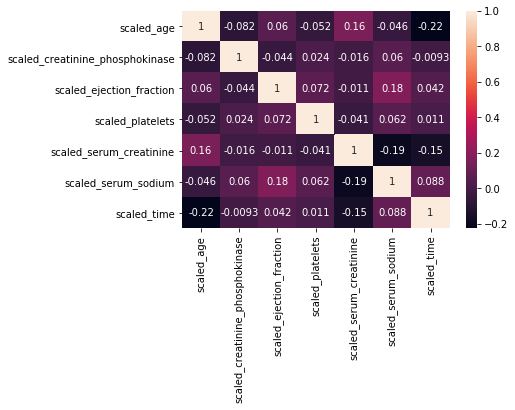

In [51]:
#ヒートマップで相関を見る　
new_df_corr_num = new_df[new_columns_num].corr()
sns.heatmap(new_df_corr_num, annot=True)


In [52]:
print(columns_cate)
print(new_columns_num)

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']
['scaled_age', 'scaled_creatinine_phosphokinase', 'scaled_ejection_fraction', 'scaled_platelets', 'scaled_serum_creatinine', 'scaled_serum_sodium', 'scaled_time']


In [53]:
print(len(columns_cate))
print(len(new_columns_num))

for a in columns_cate:
    print(a)

6
7
anaemia
diabetes
high_blood_pressure
sex
smoking
DEATH_EVENT


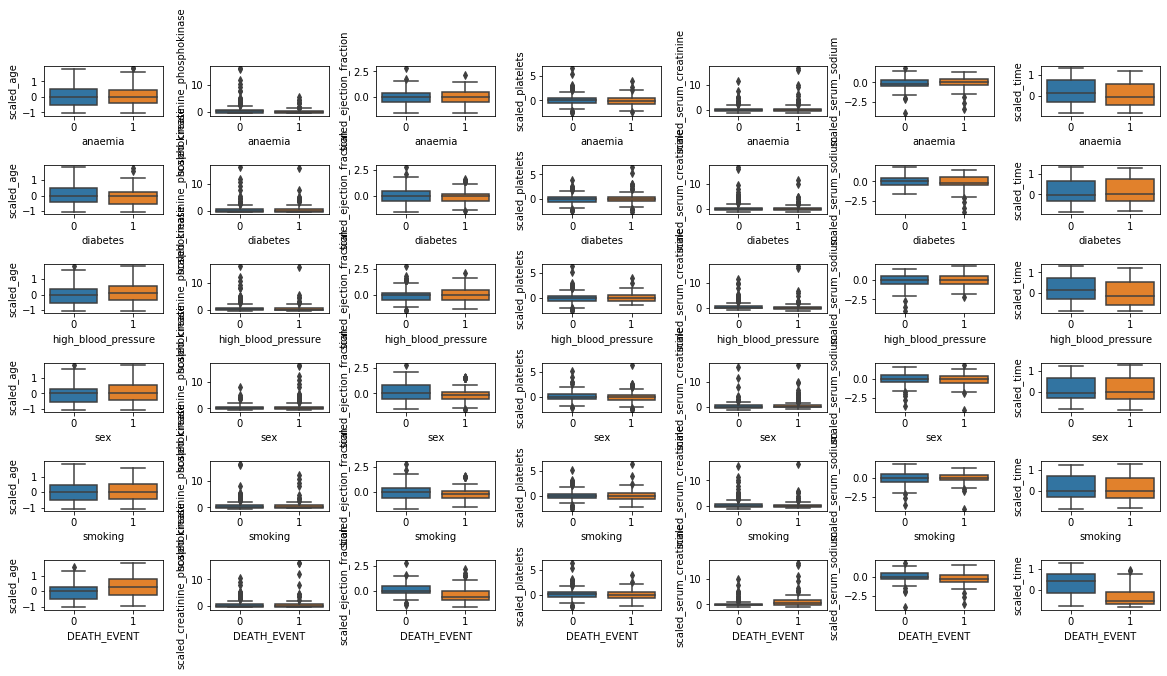

In [59]:
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(20, 10))
plt.subplots_adjust(wspace=0.4, hspace=1)

for row, cate in enumerate(columns_cate):
    for col, num in enumerate(new_columns_num):
        sns.boxplot(ax=axes[row, col], x=cate, y=num, data=new_df)

In [63]:
x = new_df.drop(["DEATH_EVENT"], axis=1)
y = new_df["DEATH_EVENT"]

In [70]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, random_state=71, shuffle=True)


In [76]:
import xgboost as xgb
from sklearn.metrics import log_loss

dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(test_x, label=test_y)

params = {"objective":"binary:logistic", 
          "eta":0.1,
          "gamma":0.0,
          "max_depth":5,
         "min_child_weight":1,
         "colsample_bytree":0.8,
         "subsample":0.8,
         "alpha":0,
         "lambda":1
         }
num_round =50

watchlist = [(dtrain, "train"), (dvalid, "eval")]
model = xgb.train(params, dtrain, num_round, evals=watchlist)

va_pred = model.predict(dvalid)
score = log_loss(test_y, va_pred)
print(f"logloss:{score:.4f}")



[13:37:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.63828	eval-logloss:0.65127
[1]	train-logloss:0.58987	eval-logloss:0.60926
[2]	train-logloss:0.54933	eval-logloss:0.57039
[3]	train-logloss:0.51518	eval-logloss:0.54298
[4]	train-logloss:0.49343	eval-logloss:0.53093
[5]	train-logloss:0.47131	eval-logloss:0.52150
[6]	train-logloss:0.45331	eval-logloss:0.51745
[7]	train-logloss:0.43187	eval-logloss:0.50238
[8]	train-logloss:0.41036	eval-logloss:0.48501
[9]	train-logloss:0.38974	eval-logloss:0.47104
[10]	train-logloss:0.37496	eval-logloss:0.45985
[11]	train-logloss:0.35638	eval-logloss:0.44760
[12]	train-logloss:0.33871	eval-logloss:0.43611
[13]	train-logloss:0.32582	eval-logloss:0.42559
[14]	train-logloss:0.31615	e

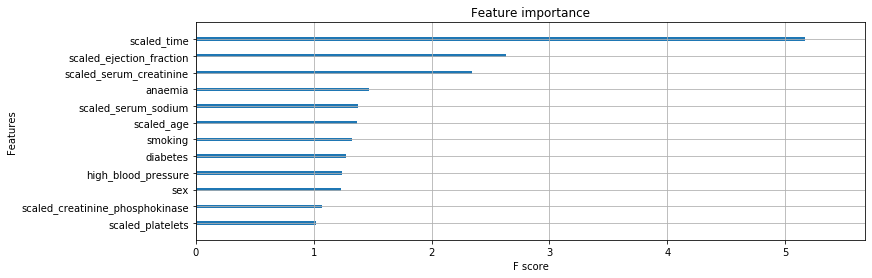

In [78]:
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.show()